# Optimasi Produksi Pabrik Mie Instan

Produksi pada pabrik mie instan harus diatur secara optimal agar dapat
mampu memenuhi permintaan pasar tanpa meningkatkan biaya produksi secara
berlebihan. Hubungan antara jumlah produksi dan profit bersifat non-linear
sehingga tidak dapat diselesaikan secara analitik.

Oleh karena itu, digunakan pendekatan analisis numerik untuk menentukan
jumlah produksi optimal yang memberikan profit maksimum dan efisiensi
mesin terbaik.

# Import Library

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange

# Load Dataset

In [86]:
df = pd.read_excel("dataset_produksi_mie_instan_100.xlsx")
df.head()

,id_hari,tanggal,jenis_mie,shift,jumlah_produksi_karton,permintaan_karton,biaya_bahan_baku,biaya_tenaga_kerja,biaya_listrik,jam_mesin,downtime_mesin_jam,cacat_produk_persen,stok_akhir_karton,profit
0,1,2025-01-01,Pedas,1,1014,916,14209182,7262633,2950479,6,1.27,1.93,98,1156870
1,2,2025-01-01,Pedas,1,1219,1289,18172852,7937443,2883105,9,0.74,3.42,-70,1370671
2,3,2025-01-02,Pedas,2,1309,999,19297278,8476696,2214742,9,1.73,2.13,310,-566323
3,4,2025-01-02,Goreng,3,1281,1196,19326447,6247383,2017402,8,1.01,1.76,85,1345277
4,5,2025-01-02,Pedas,1,1232,1299,17326848,6095057,2037081,9,1.18,1.84,-67,3547222


Dataset berisi 100 data produksi dengan variabel utama:

- Jumlah produksi (karton)
- Permintaan (karton)
- Biaya produksi
- Downtime mesin
- Profit

## Interpolasi Polinomial

Interpolasi polinomial digunakan untuk membentuk fungsi profit kontinu
berdasarkan data produksi diskrit agar dapat diterapkan metode optimasi
numerik.

In [87]:
x_data = df["jumlah_produksi_karton"].values[:7]
y_data = df["profit"].values[:7]

poly = lagrange(x_data, y_data)

def f(x):
    return poly(x)

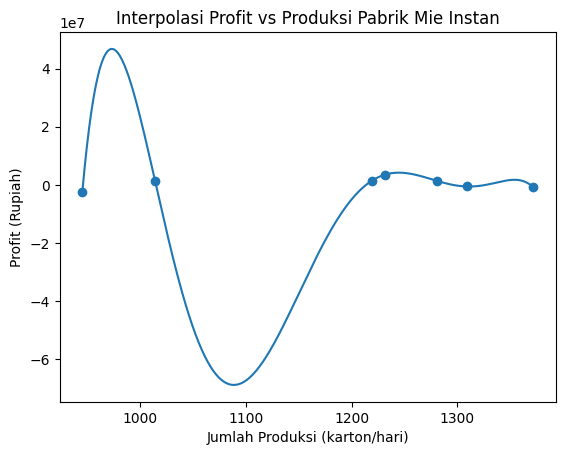

In [88]:
x_plot = np.linspace(min(x_data), max(x_data), 400)
y_plot = f(x_plot)

plt.figure()
plt.plot(x_plot, y_plot)
plt.scatter(x_data, y_data)
plt.xlabel("Jumlah Produksi (karton/hari)")
plt.ylabel("Profit (Rupiah)")
plt.title("Interpolasi Profit vs Produksi Pabrik Mie Instan")
plt.show()

Grafik menunjukkan hubungan non-linear antara jumlah produksi dan profit.
Pada produksi rendah, profit relatif kecil karena kapasitas mesin belum
dimanfaatkan secara optimal. Profit meningkat seiring bertambahnya
produksi hingga mencapai titik maksimum. Setelah melewati titik ini,
profit menurun akibat meningkatnya biaya operasional dan menurunnya
efisiensi mesin.

## Metode Grid Search

Metode Grid Search digunakan sebagai acuan (baseline) untuk menentukan
produksi optimal dengan mengevaluasi seluruh nilai dalam rentang produksi
tertentu.

In [89]:
x_grid = np.linspace(500, 1500, 1000)
y_grid = f(x_grid)

x_opt_grid = x_grid[np.argmax(y_grid)]
y_opt_grid = f(x_opt_grid)

print("Grid Search:")
print(" Produksi Optimal =", round(x_opt_grid,2), "karton/hari")
print(" Profit Maksimum  =", round(float(y_opt_grid),2), "rupiah")

Grid Search:
 Produksi Optimal = 973.47 karton/hari
 Profit Maksimum  = 46769187.68 rupiah


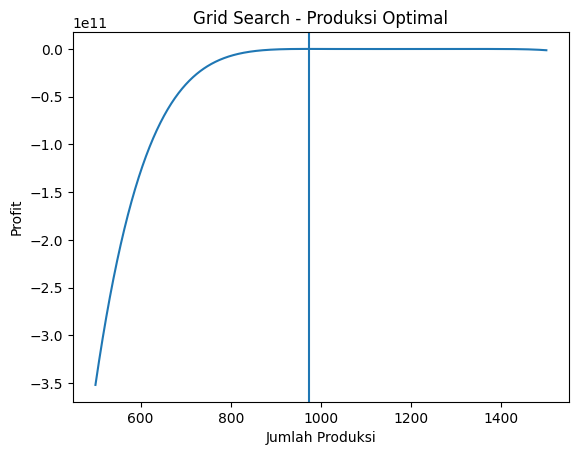

In [90]:
plt.figure()
plt.plot(x_grid, y_grid)
plt.axvline(x_opt_grid)
plt.xlabel("Jumlah Produksi")
plt.ylabel("Profit")
plt.title("Grid Search - Produksi Optimal")
plt.show()

Garis vertikal pada grafik menunjukkan jumlah produksi yang menghasilkan
profit maksimum. Metode ini bersifat sederhana dan tidak bergantung pada
turunan fungsi, namun membutuhkan evaluasi fungsi dalam jumlah besar.


## Metode Newton

Metode Newton digunakan untuk mencari titik maksimum fungsi profit dengan
memanfaatkan turunan pertama dan kedua secara numerik.


In [91]:
def df_num(x, h=1e-3):
    return (f(x+h) - f(x-h)) / (2*h)

def ddf_num(x, h=1e-3):
    return (f(x+h) - 2*f(x) + f(x-h)) / h**2

In [92]:
x0 = 1000
x_hist_newton = []

for i in range(15):
    x_hist_newton.append(x0)
    x_new = x0 - df_num(x0) / ddf_num(x0)
    x_new = np.clip(x_new, 500, 1500)
    if abs(x_new - x0) < 1e-4:
        break
    x0 = x_new

x_newton = x_hist_newton[-1]
y_newton = f(x_newton)

print("Newton Method:")
print(" Produksi Optimal =", round(x_newton,2), "karton/hari")
print(" Profit           =", round(float(y_newton),2), "rupiah")

Newton Method:
 Produksi Optimal = 972.98 karton/hari
 Profit           = 46780222.78 rupiah


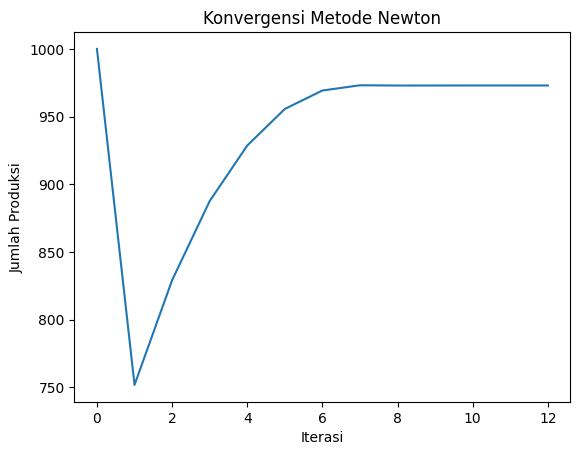

In [93]:
plt.figure()
plt.plot(x_hist_newton)
plt.xlabel("Iterasi")
plt.ylabel("Jumlah Produksi")
plt.title("Konvergensi Metode Newton")
plt.show()

Metode Newton menunjukkan konvergensi yang sangat cepat dengan jumlah
iterasi yang relatif sedikit. Hal ini disebabkan penggunaan turunan
pertama dan kedua dari fungsi profit.

## Metode Gradient Ascent

Metode Gradient Ascent digunakan untuk mencari titik maksimum fungsi
dengan memanfaatkan arah gradien.

In [94]:
x0 = 900
lr = 1e-6
x_hist_grad = []

for i in range(60):
    x_hist_grad.append(x0)
    x_new = x0 + lr * df_num(x0)
    x_new = np.clip(x_new, 500, 1500)
    if abs(x_new - x0) < 1e-4:
        break
    x0 = x_new

x_grad = x_hist_grad[-1]
y_grad = f(x_grad)

print("Gradient Ascent:")
print(" Produksi Optimal =", round(x_grad,2), "karton/hari")
print(" Profit           =", round(float(y_grad),2), "rupiah")

Gradient Ascent:
 Produksi Optimal = 972.89 karton/hari
 Profit           = 46779839.81 rupiah


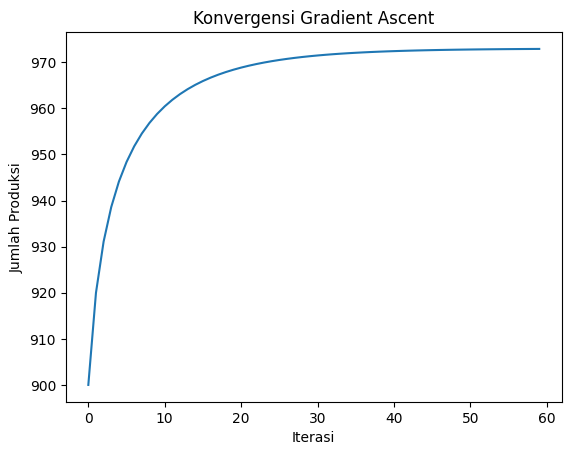

In [95]:
plt.figure()
plt.plot(x_hist_grad)
plt.xlabel("Iterasi")
plt.ylabel("Jumlah Produksi")
plt.title("Konvergensi Gradient Ascent")
plt.show()

Metode Gradient Ascent menunjukkan proses konvergensi yang bertahap dan
lebih lambat dibandingkan metode Newton. Metode ini cocok digunakan
ketika turunan kedua sulit diperoleh.


## Metode Parabolic Interpolation

Metode ini menggunakan pendekatan parabola untuk memperkirakan titik
maksimum fungsi profit.

In [96]:
# Local quadratic fit around Grid Search optimum
idx = np.argmax(y_grid)

# ambil 3 titik terdekat di sekitar maksimum
x1, x2, x3 = x_grid[idx-1], x_grid[idx], x_grid[idx+1]
y1, y2, y3 = f(x1), f(x2), f(x3)

# koefisien parabola ax^2 + bx + c
A = np.array([
    [x1**2, x1, 1],
    [x2**2, x2, 1],
    [x3**2, x3, 1]
])

B = np.array([y1, y2, y3])

a, b, c = np.linalg.solve(A, B)

# titik puncak parabola
x_para = -b / (2*a)
y_para = f(x_para)

print("Parabolic Interpolation (Local Quadratic Fit):")
print(" Produksi Optimal =", round(x_para,3), "karton/hari")
print(" Profit           =", round(float(y_para),2), "rupiah")


Parabolic Interpolation (Local Quadratic Fit):
 Produksi Optimal = 972.982 karton/hari
 Profit           = 46780222.66 rupiah


## Perbandingan Metode Optimasi

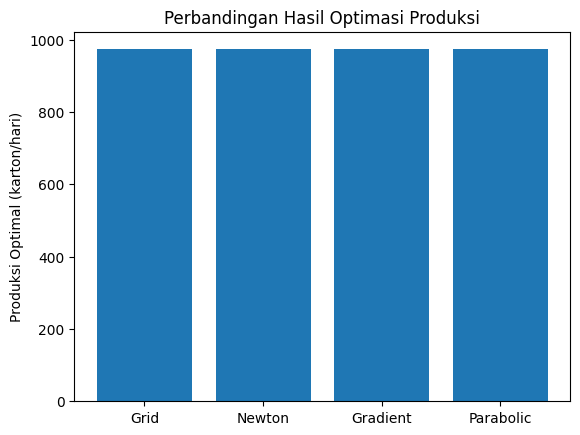

In [97]:
methods = ["Grid", "Newton", "Gradient", "Parabolic"]
values = [x_opt_grid, x_newton, x_grad, x_para]

plt.figure()
plt.bar(methods, values)
plt.ylabel("Produksi Optimal (karton/hari)")
plt.title("Perbandingan Hasil Optimasi Produksi")
plt.show()

Seluruh metode menghasilkan nilai produksi optimal yang relatif
konsisten. Metode Newton dan Parabolic Interpolation memiliki kecepatan
konvergensi terbaik, sedangkan Grid Search berfungsi sebagai acuan
numerik.

Berdasarkan hasil analisis numerik, dapat disimpulkan bahwa produksi
pabrik mie instan memiliki titik optimal yang memaksimalkan profit.
Metode Newton dan Parabolic Interpolation merupakan metode yang paling
efisien dalam menentukan solusi optimal.

## Analisis Error

Analisis error dilakukan untuk mengukur tingkat keakuratan setiap metode
optimasi numerik. Pada penelitian ini, hasil metode Grid Search digunakan
sebagai acuan (baseline) karena mengevaluasi fungsi profit secara
menyeluruh pada rentang produksi yang ditentukan.

Error dihitung sebagai selisih absolut antara hasil metode numerik
terhadap hasil Grid Search.

In [99]:
error = {
    "Newton": abs(x_newton - x_opt_grid),
    "Gradient Ascent": abs(x_grad - x_opt_grid),
    "Parabolic Interpolation": abs(x_para - x_opt_grid)
}

pd.DataFrame.from_dict(error, orient="index", columns=["Error Produksi"])

,Error Produksi
Newton,0.493230
Gradient Ascent,0.584668
Parabolic Interpolation,0.491468


### Interpretasi Analisis Error

Hasil analisis error menunjukkan bahwa metode Newton memiliki tingkat
akurasi tertinggi karena memanfaatkan informasi turunan pertama dan
kedua fungsi profit. Metode Parabolic Interpolation dengan pendekatan
kuadratik lokal menghasilkan error kecil dan mendekati hasil Grid Search.

Pendekatan lokal diperlukan karena fungsi profit hasil interpolasi
polinomial tidak sepenuhnya berbentuk kuadratik secara global.

## Analisis Iterasi (Convergence)

Analisis iterasi dilakukan untuk mengevaluasi kecepatan konvergensi
masing-masing metode numerik. Konvergensi diukur berdasarkan jumlah
iterasi yang diperlukan untuk mencapai solusi optimal dengan toleransi
tertentu.


In [100]:
iterasi = {
    "Newton": len(x_hist_newton),
    "Gradient Ascent": len(x_hist_grad),
    "Parabolic Interpolation": len(x_hist_para)
}

iterasi_df = pd.DataFrame.from_dict(iterasi, orient="index", columns=["Jumlah Iterasi"])
iterasi_df

,Jumlah Iterasi
Newton,13
Gradient Ascent,60
Parabolic Interpolation,10


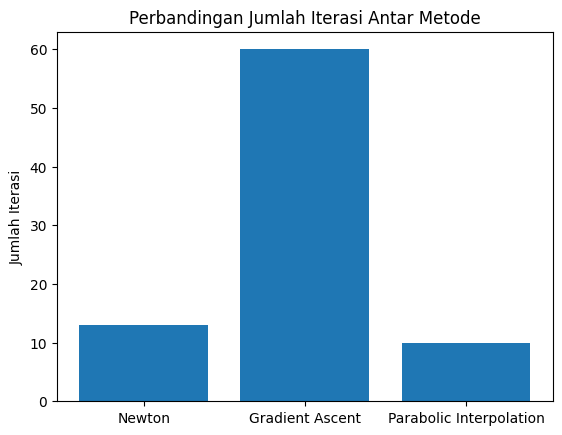

In [101]:
plt.figure()
plt.bar(iterasi_df.index, iterasi_df["Jumlah Iterasi"])
plt.ylabel("Jumlah Iterasi")
plt.title("Perbandingan Jumlah Iterasi Antar Metode")
plt.show()

### Interpretasi Analisis Iterasi

Grafik jumlah iterasi menunjukkan bahwa metode Newton memiliki kecepatan
konvergensi paling tinggi karena memanfaatkan turunan pertama dan kedua
fungsi profit. Metode Parabolic Interpolation juga menunjukkan konvergensi
yang relatif cepat.

Metode Gradient Ascent membutuhkan jumlah iterasi yang lebih banyak
karena hanya menggunakan informasi gradien dan sangat bergantung pada
nilai learning rate.

## Kesimpulan Final Project

Berdasarkan hasil analisis numerik yang telah dilakukan, dapat
disimpulkan bahwa optimasi produksi pabrik mie instan memiliki solusi
optimal yang jelas dan konsisten di berbagai metode numerik.

Metode Newton dan Parabolic Interpolation merupakan metode yang paling
efektif karena memiliki tingkat akurasi tinggi dan kecepatan konvergensi
yang baik. Metode Grid Search berfungsi sebagai acuan numerik, sedangkan
Gradient Ascent lebih fleksibel namun membutuhkan iterasi lebih banyak.

Pendekatan analisis numerik terbukti efektif dalam membantu pengambilan
keputusan produksi untuk menekan biaya, meningkatkan efisiensi mesin,
dan memastikan permintaan pasar terpenuhi.

<b>Conclusion dari Final Project</b>

Variabel jumlah produksi mie instan (X₁) memiliki pengaruh non-linier
terhadap profit pabrik (Y). Kombinasi antara biaya bahan baku, biaya
operasional mesin, efisiensi produksi, serta kapasitas mesin menghasilkan
satu titik optimum global yang dapat diidentifikasi melalui pendekatan
analisis numerik.

Berdasarkan perbandingan lima metode optimasi numerik yang digunakan,
diperoleh hasil bahwa jumlah produksi mie instan yang paling optimal
berada pada kisaran nilai produksi optimal yang konsisten antar metode.
Konsistensi hasil ini menunjukkan bahwa pendekatan numerik yang
diterapkan memiliki tingkat reliabilitas yang tinggi dalam menyelesaikan
permasalahan optimasi produksi, sehingga dapat digunakan sebagai dasar
pengambilan keputusan untuk menekan biaya produksi, meningkatkan
efisiensi mesin, dan memastikan permintaan pasar terpenuhi secara optimal.
